# 1. Imports

In [1]:
import json
from tqdm import tqdm
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import optim

from s4hci.utils.data_handling import load_adi_data
from s4hci.models.noise import S4Noise
from s4hci.models.planet import S4Planet
from s4hci.utils.adi_tools import combine_residual_stack
from s4hci.utils.masks import construct_round_rfrr_template

from sklearn.model_selection import train_test_split

from applefy.utils.fake_planets import add_fake_planets
from applefy.utils.file_handling import save_as_fits

# 2. Load the data

In [2]:
print("Loading data ... ", end='')
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data("/fast/mbonse/s4/30_data/EpsEri_0100_C-0656-A.hdf5",
                  data_tag="13_object_final",
                  psf_template_tag="10_psf",
                  para_tag="header_13_object_final/PARANG") 

psf_template_data = np.mean(raw_psf_template_data, axis=0)
print("[DONE]")

Loading data ... [DONE]


In [3]:
# Background subtraction
psf_template_data = psf_template_data - np.median(psf_template_data)
psf_template_data[psf_template_data< 0] = 0

# 3. Add a fake planet

In [4]:
#config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0188b.json"

In [39]:
config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0117a.json"

In [40]:
##config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0071a.json"

In [41]:
##config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0142b.json"

In [42]:
##config_file = "/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/exp_ID_0363f.json"

In [43]:
with open(config_file) as json_file:
    fake_planet_config = json.load(json_file)

In [44]:
fake_planet_config

{'type': 'TP estimation',
 'flux_ratio': 0.00039810717055349735,
 'separation': 6.300000000000001,
 'planet_position': [59.3, 53.0, 6.300000000000001, 0.0],
 'exp_id': '0117a'}

In [45]:
data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [46]:
# create train test splitraw_angles
X_train, X_test, angles_train , angles_test = train_test_split(
    data_with_fake_planet, raw_angles, test_size=0.0, random_state=42, shuffle=False)

ValueError: test_size=0.0 should be either positive and smaller than the number of samples 69331 or a float in the (0, 1) range

In [47]:
# This noise model was only trained on half of the images
X_train = data_with_fake_planet[0::2]
anlges_train = raw_angles[0::2]
X_test = data_with_fake_planet[1::2]
anlges_test = raw_angles[1::2]

In [48]:
X_train.shape

(34666, 107, 107)

# 4. Fine-tuning

## 4.1 Load a pre-trained noise model

Note: the noise model was trained on the data without any fake planet. This is something we want to change for the final experiments!

In [49]:
save_path_final = Path("/fast/mbonse/s4/70_results/02_fine_tuning/"
                       "implementation_tests/test_model_trained_fp64.pkl")
s4_noise = S4Noise.load(save_path_final)

Creating right reason mask ... [DONE]


## 4.2 move everything to the GPU

In [50]:
s4_noise = s4_noise.float()
s4_noise = s4_noise.to(0)

In [51]:
science_data_torch = torch.from_numpy(X_train).float()
science_data_torch = science_data_torch.to(0)

## 4.3 compute the residual without fine-tuning

In [52]:
residual_sequence, _ = s4_noise.predict(science_data_torch)

In [53]:
residual_sequence = residual_sequence.cpu().numpy()

In [54]:
# re-center around the median (not the mean)
residual_sequence -= np.median(residual_sequence, axis=0)

In [55]:
residual_before_fine_tuning = combine_residual_stack(
    residual_stack=residual_sequence,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)["Median_Residuals"]

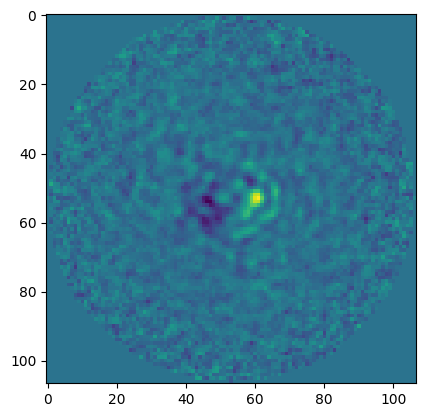

In [56]:
plt.imshow(residual_before_fine_tuning)

## 4.4 create planet model for fine-tuning

In [57]:
# Create a planet model
s4_planet_model = S4Planet(
    data_image_size=X_train.shape[-1],
    psf_template=psf_template_data,
    convolve_second=True,
    inner_mask_radius=0,
    use_up_sample=1)

In [58]:
# setup planet model for training
s4_planet_model.setup_for_training(
    all_angles=anlges_train,
    rotation_grid_down_sample=10,
    upload_rotation_grid=True)

In [59]:
s4_planet_model = s4_planet_model.to(0)

## 4.5 run fine-tuning

In [60]:
s4_noise.betas_raw.requires_grad = False

In [61]:
# The index list is needed to get all planet frames during fine-tuning. 
planet_model_idx = torch.from_numpy(
    np.arange(science_data_torch.shape[0]))

In [62]:
optimizer = optim.Adam(
    [#s4_noise.betas_raw,
     s4_planet_model.planet_model,],
    lr=1e-3,)

In [63]:
#optimizer = optim.AdamW(
##    [#s4_noise.betas_raw,
#     s4_planet_model.planet_model,],
#     lr=1e-3)

  0%|█▋                                                                                                                                                                                                                                                                                                                                     | 1/200 [00:01<06:31,  1.97s/it]

0.34534645080566406


  1%|███▎                                                                                                                                                                                                                                                                                                                                   | 2/200 [00:03<06:26,  1.95s/it]

0.34534987807273865


  2%|████▉                                                                                                                                                                                                                                                                                                                                  | 3/200 [00:05<06:23,  1.95s/it]

0.345350444316864


  2%|██████▌                                                                                                                                                                                                                                                                                                                                | 4/200 [00:07<06:21,  1.95s/it]

0.34535202383995056


  2%|████████▏                                                                                                                                                                                                                                                                                                                              | 5/200 [00:09<06:19,  1.94s/it]

0.34535181522369385


  3%|█████████▊                                                                                                                                                                                                                                                                                                                             | 6/200 [00:11<06:17,  1.94s/it]

0.3453521430492401


  4%|███████████▍                                                                                                                                                                                                                                                                                                                           | 7/200 [00:13<06:14,  1.94s/it]

0.34535327553749084


  4%|█████████████                                                                                                                                                                                                                                                                                                                          | 8/200 [00:15<06:12,  1.94s/it]

0.3453545570373535


  4%|██████████████▋                                                                                                                                                                                                                                                                                                                        | 9/200 [00:17<06:10,  1.94s/it]

0.34535539150238037
0.3453556001186371


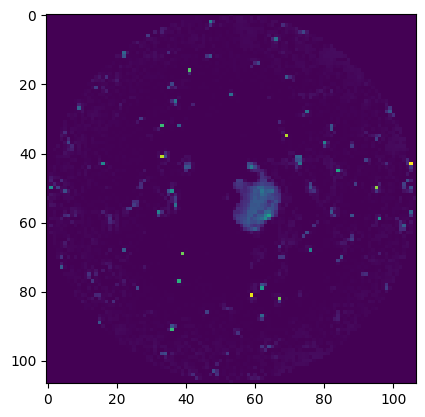

  6%|█████████████████▉                                                                                                                                                                                                                                                                                                                    | 11/200 [00:21<06:11,  1.96s/it]

0.34535592794418335


  6%|███████████████████▌                                                                                                                                                                                                                                                                                                                  | 12/200 [00:23<06:07,  1.96s/it]

0.34535685181617737


  6%|█████████████████████▏                                                                                                                                                                                                                                                                                                                | 13/200 [00:25<06:04,  1.95s/it]

0.3453579545021057


  7%|██████████████████████▊                                                                                                                                                                                                                                                                                                               | 14/200 [00:27<06:02,  1.95s/it]

0.3453581929206848


  8%|████████████████████████▍                                                                                                                                                                                                                                                                                                             | 15/200 [00:29<06:00,  1.95s/it]

0.34535762667655945


  8%|██████████████████████████                                                                                                                                                                                                                                                                                                            | 16/200 [00:31<05:57,  1.95s/it]

0.34535712003707886


  8%|███████████████████████████▋                                                                                                                                                                                                                                                                                                          | 17/200 [00:33<05:55,  1.94s/it]

0.345356822013855


  9%|█████████████████████████████▎                                                                                                                                                                                                                                                                                                        | 18/200 [00:35<05:53,  1.94s/it]

0.3453564941883087


 10%|██████████████████████████████▉                                                                                                                                                                                                                                                                                                       | 19/200 [00:37<05:51,  1.94s/it]

0.3453558385372162
0.3453551232814789


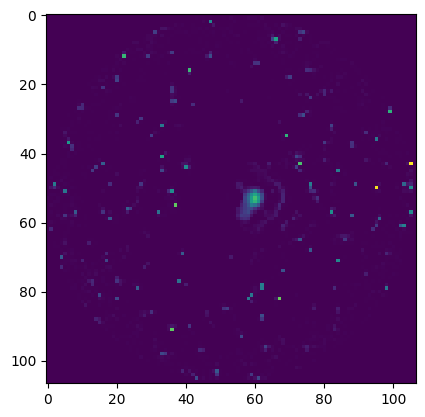

 10%|██████████████████████████████████▏                                                                                                                                                                                                                                                                                                   | 21/200 [00:41<05:51,  1.96s/it]

0.34535446763038635


 11%|███████████████████████████████████▊                                                                                                                                                                                                                                                                                                  | 22/200 [00:42<05:48,  1.96s/it]

0.34535402059555054


 12%|█████████████████████████████████████▍                                                                                                                                                                                                                                                                                                | 23/200 [00:44<05:45,  1.95s/it]

0.34535378217697144


 12%|███████████████████████████████████████                                                                                                                                                                                                                                                                                               | 24/200 [00:46<05:43,  1.95s/it]

0.34535375237464905


 12%|████████████████████████████████████████▊                                                                                                                                                                                                                                                                                             | 25/200 [00:48<05:41,  1.95s/it]

0.34535378217697144


 13%|██████████████████████████████████████████▍                                                                                                                                                                                                                                                                                           | 26/200 [00:50<05:38,  1.95s/it]

0.345353901386261


 14%|████████████████████████████████████████████                                                                                                                                                                                                                                                                                          | 27/200 [00:52<05:36,  1.95s/it]

0.3453540802001953


 14%|█████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                        | 28/200 [00:54<05:34,  1.95s/it]

0.3453541398048401


 14%|███████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                      | 29/200 [00:56<05:32,  1.94s/it]

0.34535425901412964
0.3453543782234192


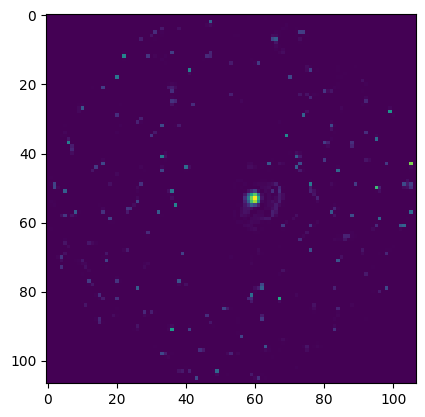

 16%|██████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                   | 31/200 [01:00<05:32,  1.97s/it]

0.34535443782806396


 16%|████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                 | 32/200 [01:02<05:29,  1.96s/it]

0.34535425901412964


 16%|█████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                | 33/200 [01:04<05:26,  1.95s/it]

0.3453541100025177


 17%|███████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                              | 34/200 [01:06<05:23,  1.95s/it]

0.34535399079322815


 18%|█████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                             | 35/200 [01:08<05:21,  1.95s/it]

0.345353901386261


 18%|██████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                           | 36/200 [01:10<05:19,  1.95s/it]

0.3453536629676819


 18%|████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                         | 37/200 [01:12<05:17,  1.95s/it]

0.3453534245491028


 19%|█████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                        | 38/200 [01:14<05:15,  1.94s/it]

0.34535327553749084


 20%|███████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                      | 39/200 [01:16<05:12,  1.94s/it]

0.34535321593284607
0.3453531861305237


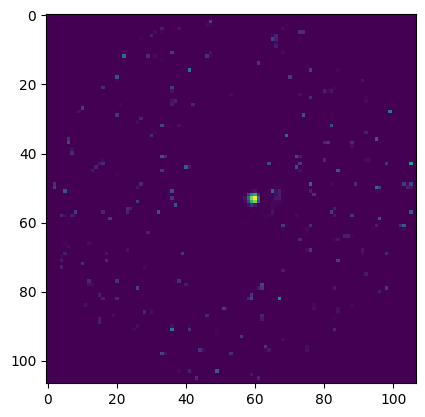

 20%|██████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                   | 41/200 [01:20<05:12,  1.97s/it]

0.3453531861305237


 21%|████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                 | 42/200 [01:22<05:09,  1.96s/it]

0.34535327553749084


 22%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                | 43/200 [01:23<05:06,  1.95s/it]

0.3453533351421356


 22%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                              | 44/200 [01:25<05:04,  1.95s/it]

0.3453534245491028


 22%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                            | 45/200 [01:27<05:02,  1.95s/it]

0.3453533947467804


 23%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                           | 46/200 [01:29<04:59,  1.95s/it]

0.3453533351421356


 24%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                         | 47/200 [01:31<04:57,  1.95s/it]

0.3453533351421356


 24%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                       | 48/200 [01:33<04:55,  1.94s/it]

0.34535327553749084


 24%|███████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                      | 49/200 [01:35<04:53,  1.94s/it]

0.34535327553749084
0.3453531563282013


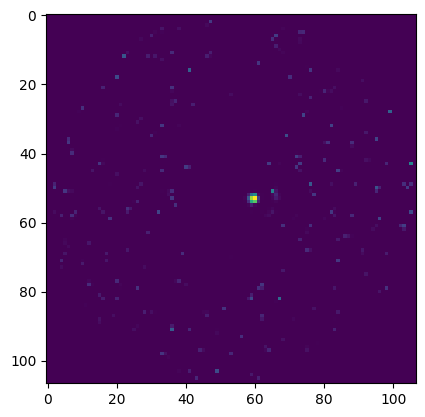

 26%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                  | 51/200 [01:39<04:53,  1.97s/it]

0.34535306692123413


 26%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                 | 52/200 [01:41<04:50,  1.96s/it]

0.34535297751426697


 26%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                               | 53/200 [01:43<04:47,  1.95s/it]

0.3453529477119446


 27%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                              | 54/200 [01:45<04:44,  1.95s/it]

0.3453529477119446


 28%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                            | 55/200 [01:47<04:42,  1.95s/it]

0.3453528881072998


 28%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                          | 56/200 [01:49<04:40,  1.95s/it]

0.34535282850265503


 28%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                         | 57/200 [01:51<04:38,  1.95s/it]

0.34535276889801025


 29%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                       | 58/200 [01:53<04:36,  1.94s/it]

0.3453528881072998


 30%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                     | 59/200 [01:55<04:34,  1.94s/it]

0.34535297751426697
0.34535297751426697


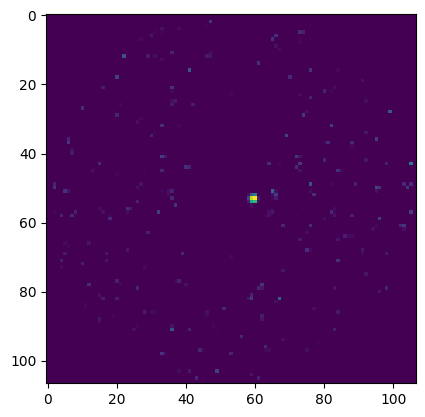

 30%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                  | 61/200 [01:59<04:33,  1.97s/it]

0.3453529477119446


 31%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                 | 62/200 [02:01<04:30,  1.96s/it]

0.3453528881072998


 32%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                               | 63/200 [02:03<04:27,  1.95s/it]

0.3453528881072998


 32%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                             | 64/200 [02:04<04:25,  1.95s/it]

0.3453528881072998


 32%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                            | 65/200 [02:06<04:22,  1.95s/it]

0.34535282850265503


 33%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                          | 66/200 [02:08<04:20,  1.95s/it]

0.34535276889801025


 34%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                        | 67/200 [02:10<04:18,  1.95s/it]

0.34535273909568787


 34%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                       | 68/200 [02:12<04:16,  1.94s/it]

0.34535273909568787


 34%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                     | 69/200 [02:14<04:14,  1.94s/it]

0.34535273909568787
0.34535273909568787


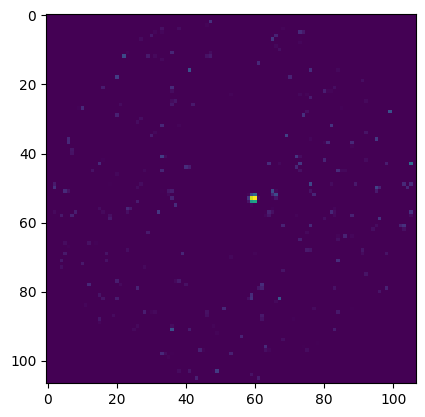

 36%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                  | 71/200 [02:18<04:13,  1.97s/it]

0.3453527092933655


 36%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                | 72/200 [02:20<04:11,  1.96s/it]

0.34535273909568787


 36%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                               | 73/200 [02:22<04:08,  1.96s/it]

0.34535276889801025


 37%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                             | 74/200 [02:24<04:05,  1.95s/it]

0.34535276889801025


 38%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                           | 75/200 [02:26<04:03,  1.95s/it]

0.34535276889801025


 38%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                          | 76/200 [02:28<04:01,  1.95s/it]

0.34535276889801025


 38%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                        | 77/200 [02:30<03:59,  1.95s/it]

0.34535276889801025


 39%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                      | 78/200 [02:32<03:57,  1.94s/it]

0.3453527092933655


 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                     | 79/200 [02:34<03:55,  1.94s/it]

0.3453527092933655
0.3453526496887207


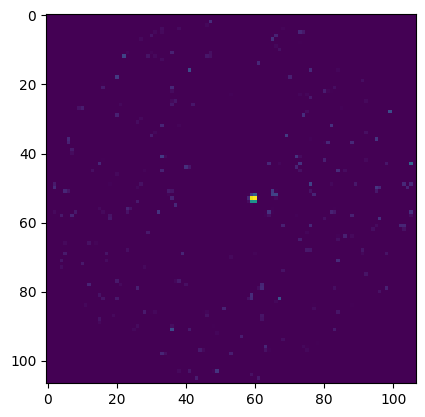

 40%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 81/200 [02:38<03:54,  1.97s/it]

0.34535273909568787


 41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                                | 82/200 [02:40<03:51,  1.96s/it]

0.3453527092933655


 42%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                              | 83/200 [02:42<03:48,  1.95s/it]

0.3453526198863983


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                             | 84/200 [02:44<03:46,  1.95s/it]

0.3453527092933655


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                           | 85/200 [02:46<03:44,  1.95s/it]

0.3453527092933655


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                         | 86/200 [02:47<03:41,  1.95s/it]

0.3453527092933655


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 87/200 [02:49<03:39,  1.95s/it]

0.3453527092933655
0.3453526496887207


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                     | 89/200 [02:53<03:36,  1.95s/it]

0.3453527092933655
0.34535273909568787


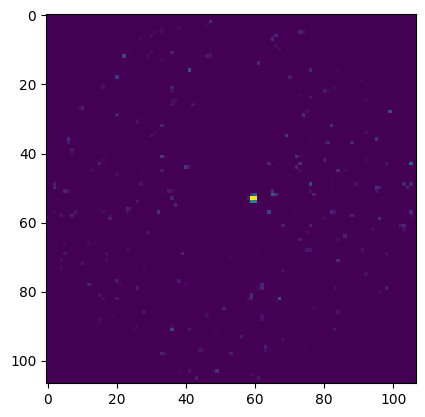

 46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                 | 91/200 [02:57<03:34,  1.97s/it]

0.3453527092933655
0.3453526198863983


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                              | 93/200 [03:01<03:29,  1.96s/it]

0.3453527092933655


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                            | 94/200 [03:03<03:27,  1.96s/it]

0.3453527092933655


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                           | 95/200 [03:05<03:25,  1.95s/it]

0.3453526198863983


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                         | 96/200 [03:07<03:22,  1.95s/it]

0.3453526198863983


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                        | 97/200 [03:09<03:20,  1.95s/it]

0.3453527092933655


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                      | 98/200 [03:11<03:18,  1.95s/it]

0.34535273909568787


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                    | 99/200 [03:13<03:16,  1.95s/it]

0.3453527092933655
0.34535273909568787


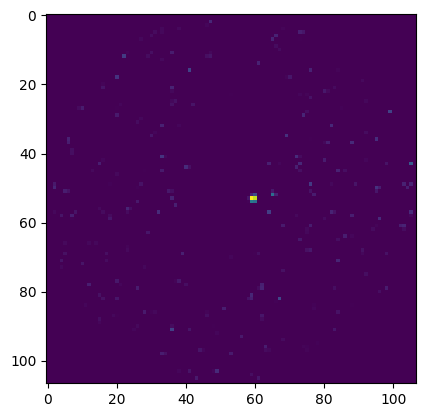

 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                | 101/200 [03:17<03:14,  1.97s/it]

0.3453527092933655


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 102/200 [03:19<03:12,  1.96s/it]

0.3453527092933655
0.3453527092933655


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                            | 104/200 [03:23<03:07,  1.96s/it]

0.3453526198863983
0.3453526496887207


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                        | 106/200 [03:27<03:03,  1.95s/it]

0.3453527092933655


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 107/200 [03:29<03:01,  1.95s/it]

0.3453527092933655


 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 108/200 [03:30<02:59,  1.95s/it]

0.3453525900840759


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                   | 109/200 [03:32<02:57,  1.95s/it]

0.3453526496887207
0.3453526496887207


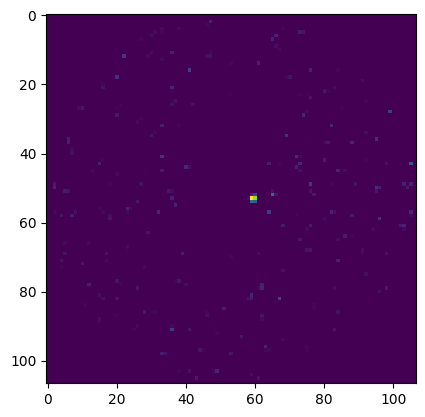

 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 111/200 [03:36<02:55,  1.97s/it]

0.3453526496887207


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                               | 112/200 [03:38<02:52,  1.96s/it]

0.3453526198863983


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                             | 113/200 [03:40<02:50,  1.96s/it]

0.3453526198863983


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 114/200 [03:42<02:47,  1.95s/it]

0.3453527092933655


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                          | 115/200 [03:44<02:45,  1.95s/it]

0.3453526198863983


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                        | 116/200 [03:46<02:43,  1.95s/it]

0.3453526198863983


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                      | 117/200 [03:48<02:41,  1.95s/it]

0.3453527092933655


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 118/200 [03:50<02:39,  1.94s/it]

0.3453526198863983


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 119/200 [03:52<02:37,  1.94s/it]

0.3453526198863983
0.3453527092933655


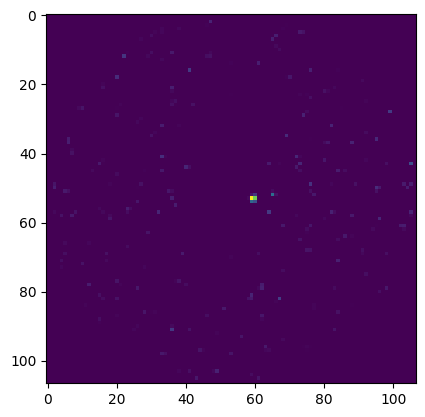

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                | 121/200 [03:56<02:35,  1.97s/it]

0.3453526198863983


 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                              | 122/200 [03:58<02:32,  1.96s/it]

0.3453527092933655


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 123/200 [04:00<02:30,  1.95s/it]

0.3453526198863983


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 124/200 [04:02<02:28,  1.95s/it]

0.3453525900840759


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                         | 125/200 [04:04<02:26,  1.95s/it]

0.3453527092933655


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 126/200 [04:06<02:24,  1.95s/it]

0.3453526198863983


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 127/200 [04:08<02:21,  1.94s/it]

0.3453526198863983


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                     | 128/200 [04:10<02:20,  1.95s/it]

0.3453526198863983


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                   | 129/200 [04:11<02:18,  1.94s/it]

0.3453526198863983
0.3453525900840759


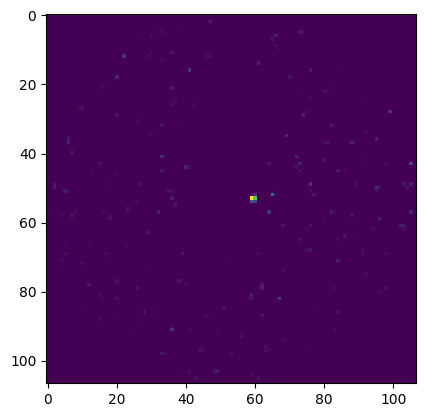

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 131/200 [04:15<02:15,  1.97s/it]

0.3453526496887207


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 132/200 [04:17<02:13,  1.96s/it]

0.3453526198863983


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                            | 133/200 [04:19<02:11,  1.96s/it]

0.34535253047943115


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                           | 134/200 [04:21<02:08,  1.95s/it]

0.3453526198863983


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                         | 135/200 [04:23<02:06,  1.95s/it]

0.3453526198863983


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 136/200 [04:25<02:04,  1.95s/it]

0.3453525900840759
0.34535253047943115


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                    | 138/200 [04:29<02:00,  1.94s/it]

0.3453525900840759


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 139/200 [04:31<01:58,  1.94s/it]

0.3453526198863983
0.34535253047943115


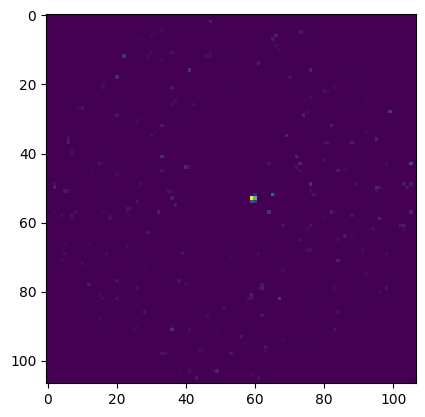

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 141/200 [04:35<01:56,  1.97s/it]

0.3453525900840759


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 142/200 [04:37<01:53,  1.96s/it]

0.3453525900840759
0.3453525900840759


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 144/200 [04:41<01:49,  1.95s/it]

0.3453526198863983
0.3453526198863983


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 146/200 [04:45<01:45,  1.95s/it]

0.34535253047943115


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 147/200 [04:47<01:43,  1.95s/it]

0.34535253047943115


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 148/200 [04:49<01:41,  1.94s/it]

0.3453526198863983


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 149/200 [04:51<01:39,  1.94s/it]

0.3453525900840759
0.34535253047943115


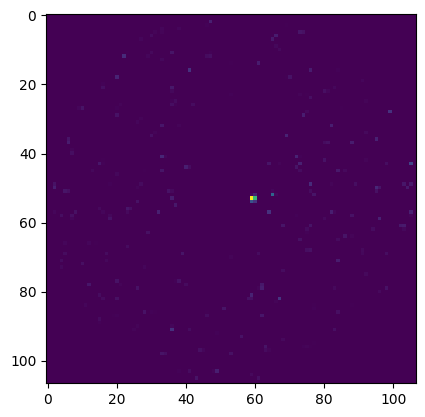

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 151/200 [04:55<01:36,  1.96s/it]

0.34535253047943115


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 152/200 [04:57<01:33,  1.96s/it]

0.3453525900840759


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 153/200 [04:58<01:31,  1.95s/it]

0.34535253047943115


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 154/200 [05:00<01:29,  1.95s/it]

0.3453525900840759


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 155/200 [05:02<01:27,  1.95s/it]

0.34535253047943115


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 156/200 [05:04<01:25,  1.95s/it]

0.34535253047943115
0.3453526198863983


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 158/200 [05:08<01:21,  1.95s/it]

0.3453525900840759
0.34535250067710876


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 159/200 [05:10<01:19,  1.94s/it]

0.34535253047943115


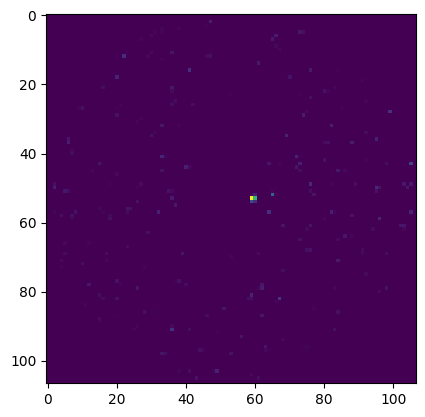

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 161/200 [05:14<01:17,  1.98s/it]

0.3453525900840759


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 162/200 [05:16<01:14,  1.97s/it]

0.34535250067710876


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 163/200 [05:18<01:12,  1.96s/it]

0.3453525900840759


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 164/200 [05:20<01:10,  1.96s/it]

0.3453525900840759
0.3453525900840759


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 166/200 [05:24<01:06,  1.95s/it]

0.34535253047943115


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 167/200 [05:26<01:04,  1.95s/it]

0.34535253047943115
0.34535250067710876


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 169/200 [05:30<01:00,  1.94s/it]

0.34535250067710876
0.3453526198863983


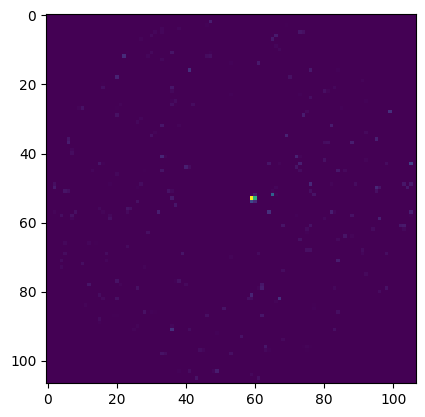

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 171/200 [05:34<00:57,  1.97s/it]

0.34535253047943115


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 172/200 [05:36<00:54,  1.96s/it]

0.3453524708747864
0.3453526198863983


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 174/200 [05:40<00:50,  1.96s/it]

0.34535253047943115


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 175/200 [05:41<00:48,  1.95s/it]

0.3453524708747864


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 176/200 [05:43<00:46,  1.95s/it]

0.3453525900840759
0.34535250067710876


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 178/200 [05:47<00:42,  1.95s/it]

0.34535250067710876


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 179/200 [05:49<00:40,  1.95s/it]

0.34535250067710876
0.3453525900840759


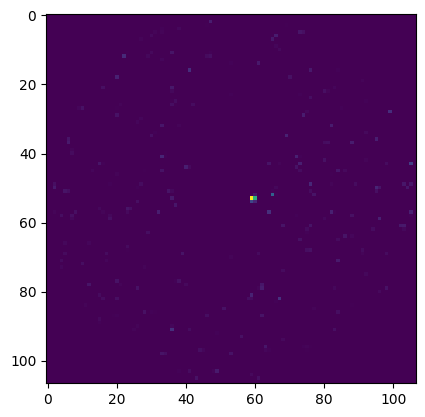

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 181/200 [05:53<00:37,  1.97s/it]

0.3453525900840759
0.34535253047943115


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 183/200 [05:57<00:33,  1.95s/it]

0.3453525900840759


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 184/200 [05:59<00:31,  1.95s/it]

0.34535253047943115


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 185/200 [06:01<00:29,  1.95s/it]

0.34535250067710876
0.34535250067710876


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 187/200 [06:05<00:25,  1.95s/it]

0.3453525900840759


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 188/200 [06:07<00:23,  1.94s/it]

0.34535253047943115


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 189/200 [06:09<00:21,  1.94s/it]

0.34535253047943115
0.3453525900840759


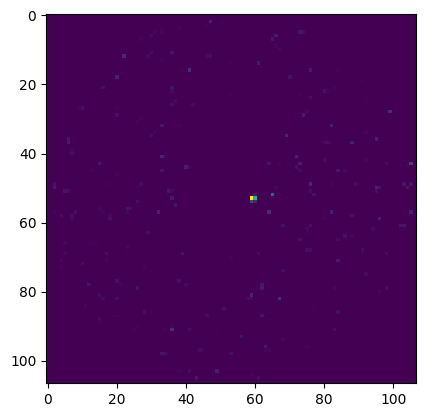

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 191/200 [06:13<00:17,  1.96s/it]

0.34535250067710876


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 192/200 [06:15<00:15,  1.96s/it]

0.3453524708747864


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 193/200 [06:17<00:13,  1.95s/it]

0.34535250067710876
0.3453525900840759


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 195/200 [06:21<00:09,  1.95s/it]

0.3453525900840759


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 196/200 [06:22<00:07,  1.95s/it]

0.3453524112701416
0.3453525900840759


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 198/200 [06:26<00:03,  1.94s/it]

0.3453525900840759
0.3453523814678192


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 199/200 [06:28<00:01,  1.94s/it]

0.34535253047943115


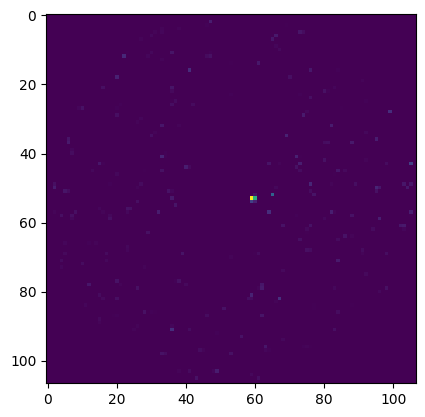

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [06:30<00:00,  1.95s/it]


In [64]:
losses_recon = []
losses_reg = []

for epoch in tqdm(range(200)):
    optimizer.zero_grad()
    
    # 1.) Get the current planet signal estimate
    planet_signal = s4_planet_model.forward(planet_model_idx)
    
    # 2.) Get the current data without the planet
    data_no_planet = science_data_torch - planet_signal.squeeze().detach()
    
    # 3.) Setup the normalization
    X_mu = torch.mean(data_no_planet, axis=0)
    X_std = torch.std(data_no_planet, axis=0)
    
    # 4.) get the current normalized data
    X_norm = (science_data_torch - X_mu) / X_std
    planet_signal_norm = planet_signal / X_std
    
    # 5.) reshape everything 
    planet_signal_norm = planet_signal_norm.view(
        science_data_torch.shape[0], -1)
    science_norm_flatten = X_norm.view(
        X_norm.shape[0], -1)
    
    # 6.) run the forward path
    P_hat_N = s4_noise(planet_signal_norm)
    P_hat_N[P_hat_N>0] = 0
    
    noise_estimate = s4_noise(science_norm_flatten) - P_hat_N

    # 7.) estimate the modeled data
    modeled_data = noise_estimate + planet_signal_norm
    
    # 8.) Compute the loss       
    loss_recon = ((modeled_data - science_norm_flatten)**2).mean()
    loss_reg = (s4_noise.betas_raw**2).mean()

    # 9.) Backward 
    loss = loss_recon + loss_reg * s4_noise.lambda_reg
    loss.backward()

    optimizer.step()

    # 10.) Print the loss terms
    losses_recon.append(loss_recon.item())
    print(loss_recon.item())
    
    if epoch % 10 == 9:
        # plot the planet signal
        with torch.no_grad():
            tmp_norm_signal = s4_planet_model.get_planet_signal() / X_std.detach()
            plt.imshow(tmp_norm_signal.cpu().numpy()[0])
            plt.show()

In [65]:
# 1.) Get the current planet signal estimate
planet_signal = s4_planet_model.forward(planet_model_idx)

# 2.) Get the current data without the planet
data_no_planet = science_data_torch - planet_signal.squeeze().detach()

# 3.) Setup the normalization
X_mu = torch.mean(data_no_planet, axis=0)
X_std = torch.std(data_no_planet, axis=0)

# 4.) get the current normalized data
X_norm = (science_data_torch - X_mu) / X_std
X_no_planet = (science_data_torch - planet_signal.squeeze() - X_mu) / X_std
    
# 5.) reshape everything 
science_norm_flatten = X_norm.view(
    X_norm.shape[0], -1)

science_norm_flatten_no_planet = X_no_planet.view(
    X_norm.shape[0], -1)

noise_estimate = s4_noise(science_norm_flatten_no_planet)

In [66]:
# compute the residual
residual_squence = science_norm_flatten - noise_estimate
residual_stack = residual_squence.view(
    science_data_torch.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

In [67]:
residuals_unbiased = science_norm_flatten_no_planet - noise_estimate
residuals_unbiased = residuals_unbiased.view(
    science_data_torch.shape[0], 
    s4_noise.image_size,
    s4_noise.image_size).detach().cpu().numpy()

unbiased_median_frame = np.median(residuals_unbiased, axis=0)

In [68]:
residual_stack = residual_stack - unbiased_median_frame

residual_after_fine_tuning = combine_residual_stack(
    residual_stack=residual_stack,
    angles=anlges_train,
    combine=["Median_Residuals",],
    suffix="",
    num_cpus=8)["Median_Residuals"]

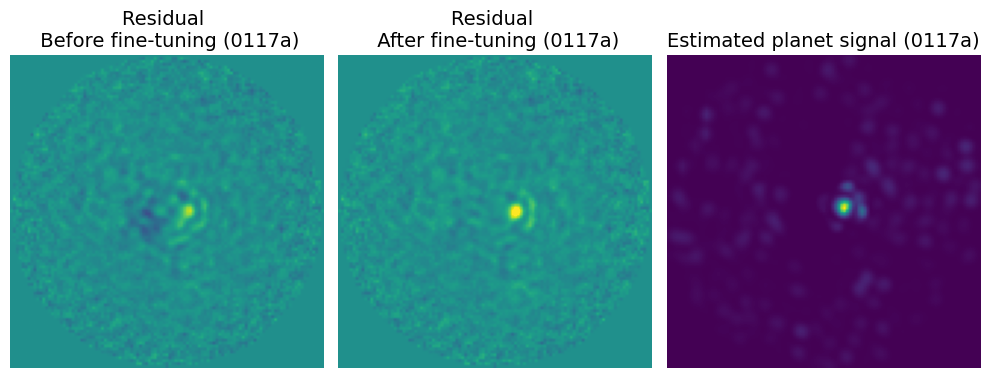

In [73]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))

limit = 0.05
fake_planet_id = config_file[-10:-5]

ax1.imshow(residual_before_fine_tuning,
           vmin=-limit, vmax=limit)
ax1.set_title(
    "Residual \n Before fine-tuning (" + fake_planet_id + ")",
    fontsize=14)
ax1.axis("off")

ax2.imshow(residual_after_fine_tuning,
           vmin=-limit, vmax=limit)
ax2.set_title(
    "Residual \n After fine-tuning (" + fake_planet_id + ")",
    fontsize=14)
ax2.axis("off")


ax3.imshow((planet_signal / X_std).cpu().detach().numpy()[-1, 0])

ax3.set_title(
    "Estimated planet signal (" + fake_planet_id + ")",
    fontsize=14)
ax3.axis("off")

plt.tight_layout()
plt.savefig("Fine_tuning_" + fake_planet_id + ".pdf")

In [70]:
save_as_fits(
    residual_before_fine_tuning,
    fake_planet_id + "_before_fine_tune.fits"
)

save_as_fits(
    residual_after_fine_tuning,
    fake_planet_id + "_after_fine_tune.fits"
)

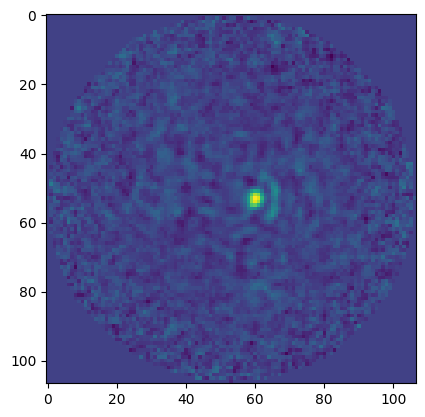

In [71]:
plt.imshow(residual_after_fine_tuning)